<a href="https://www.kaggle.com/code/suryateja35/30day-sales-forecast?scriptVersionId=212263666" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
file_path = '/kaggle/input/sales-transaction/Sales_transaction_gross_sales.csv'
sales_data = pd.read_csv(file_path)

In [3]:
# Convert 'TRANSACTION_DATE' to datetime format
sales_data['TRANSACTION_DATE'] = pd.to_datetime(sales_data['TRANSACTION_DATE'])

In [4]:
# Remove rows with negative sales values
sales_data = sales_data[sales_data['ESTIMATED_GROSS_PROFIT_AMOUNT'] >= 0]

In [5]:
# Aggregate data by day to ensure one entry per day
daily_sales = sales_data.groupby('TRANSACTION_DATE')['ESTIMATED_GROSS_PROFIT_AMOUNT'].sum().reset_index()
print(daily_sales)

     TRANSACTION_DATE  ESTIMATED_GROSS_PROFIT_AMOUNT
0          2020-01-02                       19759.60
1          2020-01-03                       17195.57
2          2020-01-05                       17485.47
3          2020-01-06                       22110.86
4          2020-01-07                       14211.80
...               ...                            ...
1589       2024-12-02                      767568.56
1590       2024-12-03                      534608.51
1591       2024-12-04                      530186.29
1592       2024-12-05                      532576.96
1593       2024-12-06                        1117.94

[1594 rows x 2 columns]


In [6]:
# Generate a continuous date range
date_range = pd.date_range(start=daily_sales['TRANSACTION_DATE'].min(), 
                           end=daily_sales['TRANSACTION_DATE'].max())
print(date_range)

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2024-11-27', '2024-11-28', '2024-11-29', '2024-11-30',
               '2024-12-01', '2024-12-02', '2024-12-03', '2024-12-04',
               '2024-12-05', '2024-12-06'],
              dtype='datetime64[ns]', length=1801, freq='D')


In [7]:
#Merge with the full date range, filling missing dates with 0
daily_sales = daily_sales.set_index('TRANSACTION_DATE').reindex(date_range, fill_value=0).reset_index()
daily_sales.rename(columns={'index': 'ds', 'ESTIMATED_GROSS_PROFIT_AMOUNT': 'y'}, inplace=True)


In [8]:
model = Prophet()
model.fit(daily_sales)

08:20:17 - cmdstanpy - INFO - Chain [1] start processing
08:20:17 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
#Forecast the next 3 months (90 days)
future_dates = model.make_future_dataframe(periods=30)  # Add 90 days to the time series
forecast = model.predict(future_dates)

In [10]:
forecast.to_csv("/kaggle/working/sales_forecast_corrected.csv", index=False)
print("Forecast saved as 'sales_forecast_corrected.csv'.")


Forecast saved as 'sales_forecast_corrected.csv'.


             ds         trend     yhat_lower     yhat_upper   trend_lower  \
0    2020-01-02  29993.662564  -55117.948668   89188.663988  29993.662564   
1    2020-01-03  30127.630569  -53060.626165   97254.246915  30127.630569   
2    2020-01-04  30261.598574 -117003.043646   31359.561124  30261.598574   
3    2020-01-05  30395.566579  -93595.487864   56184.538540  30395.566579   
4    2020-01-06  30529.534584   18684.104203  165521.937033  30529.534584   
...         ...           ...            ...            ...           ...   
1826 2025-01-01  97874.157008   24031.000182  172016.921986  97832.716352   
1827 2025-01-02  97906.432005   18530.051830  162196.226429  97858.433833   
1828 2025-01-03  97938.707001   21901.060067  163991.181028  97882.050785   
1829 2025-01-04  97970.981998  -46141.043816  101281.885796  97907.777861   
1830 2025-01-05  98003.256994  -19756.071176  126283.470646  97928.873627   

       trend_upper  additive_terms  additive_terms_lower  \
0     29993.662

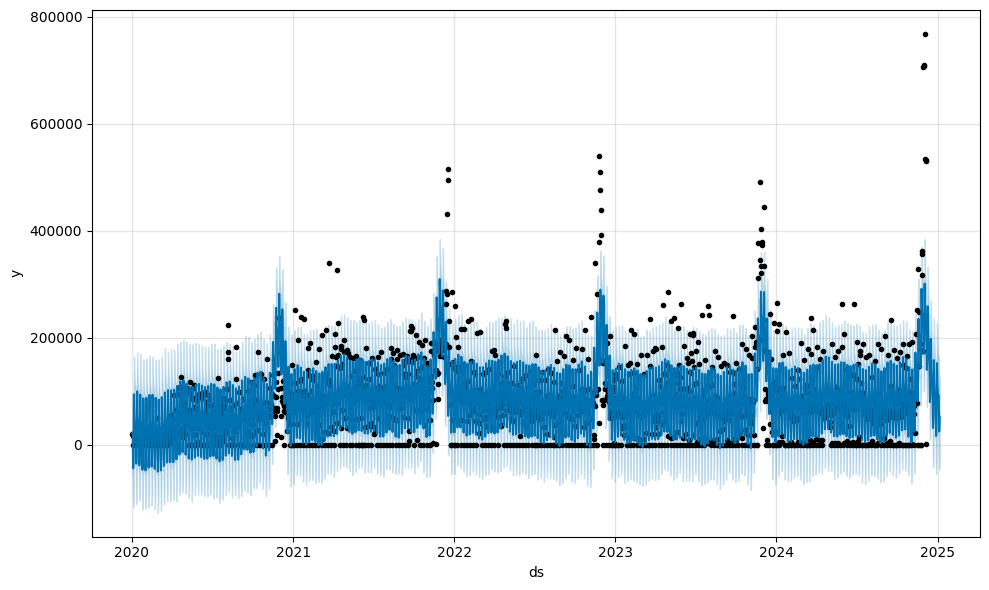

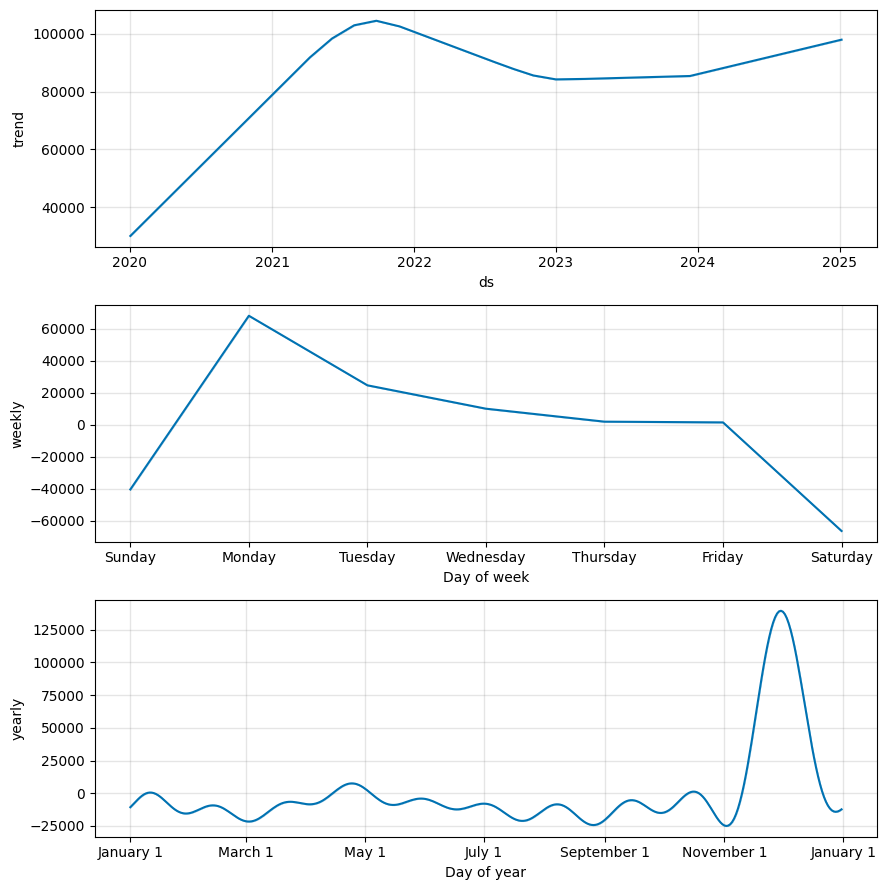

In [11]:
model.plot(forecast)
model.plot_components(forecast)
print(forecast)

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
# Actual values
actual = daily_sales['y']

# Predicted values (match the dates to actual data)
predicted = forecast.loc[:len(actual)-1, 'yhat']

In [13]:
adjusted_actual = np.where(actual == 0, 1e-10, actual)
mape = np.mean(np.abs((actual - predicted) / adjusted_actual)) * 100

print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 3285515208568656.5%


In [14]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 57585.4835852233


In [15]:
comparison = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
print(comparison.head(10))

     Actual     Predicted
0  19759.60  21674.471252
1  17195.57  22874.178263
2      0.00 -43303.590449
3  17485.47 -15628.963063
4  22110.86  94609.441652
5  14211.80  52602.938119
6  12666.62  39289.003840
7  14582.29  32253.875947
8  12302.08  32622.405602
9      0.00 -34724.812235
